### Look at individually

### Pull up Vitals Sign info & RRT events from clinical event table.
#### In order to answer these questions:
    1. Which of the vital signs are actually recorded the most? (e.g. between the different O2 measures)
         We would want to use these measurements -- the ones that are most accessible / most often recorded
         
    2. How many measurements are available from the same encounter before a patient"s RRT event? What"s the time frame we have before RRT events?
        Use this info to help us shape how we timebox measurements for prediction.

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [71]:
import datetime as datetime

In [72]:
from impala.util import as_pandas
# cur.execute(query)
# df = as_pandas(cur)

In [73]:
# connect to impala
from impala.dbapi import connect
conn = connect(host="socbddn01.sharp.com", port=21050)

In [74]:
# Make sure we"re pulling from the right location
cur = conn.cursor()
cur.execute("use poc_sandbox")

In [332]:
query = "SELECT ce.clinical_event_id, ce.event_id \
,ce.encntr_id ,ce.person_id \
,ce.event_cd , cv_event_cd.description AS event_description \
,ce.performed_dt_tm AS unix_performed_dt_tm \
,from_unixtime(CAST(ce.performed_dt_tm   / 1000 as bigint)) AS performed_dt_tm \
,ce.event_tag ,ce.result_val ,cv_result_units_cd.display      AS result_units_display \
,ce.result_time_units_cd \
,ce.catalog_cd \
FROM clinical_event        ce \
LEFT OUTER JOIN code_value   cv_event_cd ON   ce.event_cd           = cv_event_cd.code_value \
LEFT OUTER JOIN code_value   cv_result_units_cd ON   ce.result_units_cd    = cv_result_units_cd.code_value \
WHERE ce.encntr_id IN ( SELECT DISTINCT encntr_id \
                       FROM clinical_event \
                       WHERE event_cd = '54411998' \
                       AND result_status_cd NOT IN ('31', '36') \
                       AND valid_until_dt_tm > unix_timestamp() \
                       AND event_class_cd not in ('654645') \
                       ORDER BY RAND() \
                       LIMIT 10 \
                      ) \
AND ce.event_cd IN ( \
'703306',\
'703501',\
'703511',\
'703516',\
'703540',\
'703558',\
'703565',\
'703569',\
'703960',\
'2700541',\
'2700653',\
'3623994',\
'4674677',\
'4686698',\
'54411998'\
)\
ORDER BY ce.encntr_id, ce.performed_dt_tm;"

In [333]:
cur.execute(query)
df = as_pandas(cur)

In [334]:
df.head()

,clinical_event_id,event_id,encntr_id,person_id,event_cd,event_description,unix_performed_dt_tm,performed_dt_tm,event_tag,result_val,result_units_display,result_time_units_cd,catalog_cd
0,7195693683,7195693684,104240694,27036389,703558,Temperature Oral,1452450470000,2016-01-10 18:27:50,36.5,36.5,DegC,0,0
1,7195693689,7195693690,104240694,27036389,703501,Systolic Blood Pressure,1452450486000,2016-01-10 18:28:06,175,175,mmHg,0,0
2,7195693697,7195693698,104240694,27036389,703516,Diastolic Blood Pressure,1452450486000,2016-01-10 18:28:06,86,86,mmHg,0,0
3,7195693725,7195693726,104240694,27036389,703306,Mean Arterial Pressure,1452450489000,2016-01-10 18:28:09,116,116,mmHg,0,0
4,7195693707,7195693708,104240694,27036389,703540,Respiratory Rate,1452450512000,2016-01-10 18:28:32,18,18,br/min,0,0


In [335]:
df.encntr_id.value_counts()

105041972    8269
108285121    5196
111099716    2761
108491995    1600
110131495    1571
105335481    1304
105479870     943
111194849     894
104240694     645
110017516     236
Name: encntr_id, dtype: int64

In [260]:
# pull off all the encounter ids into an array to loop over
df.encntr_id.value_counts().index.get_values()

array(['108285121', '110131495', '105479870', '111194849', '110017516'], dtype=object)

In [262]:
df_enc = df[df.encntr_id=='108285121']
rrt_times = df_enc.unix_performed_dt_tm[df_enc.event_cd == '54411998'].unique()

In [265]:
rrt_times

array([1462655175000])

In [316]:
newdf = df_enc.groupby(['event_cd']).count().iloc[:,0].to_frame()

In [321]:
newdf

,clinical_event_id
event_cd,
2700541,452
2700653,6
3623994,690
4674677,34
4686698,141
54411998,2
703306,598
703501,644
703511,212


In [320]:
print newdf.sort_values('clinical_event_id', ascending = False)

          clinical_event_id
event_cd                   
3623994                 690
703501                  644
703516                  641
703540                  638
703306                  598
703960                  521
2700541                 452
703569                  380
703511                  212
703558                  174
4686698                 141
703565                   63
4674677                  34
2700653                   6
54411998                  2


In [338]:
#Function to show how many values of different vitals signs for event_cd appeared in the intervals between RRT events 
#for this encounterid
#Start with a df from clinical_event table, where each line contains either a vital sign reading or an RRT event form
#must include encntr_id, event_cd, unixdatestamp

def output_vitalsbeforeRRT(df):
    '''
    Function to show how many values of different vitals signs for event_cd appeared in the intervals between RRT events 
for this encounterid Start with a df from clinical_event table, where each line contains either a vital sign reading or 
an RRT event form must include encntr_id, event_cd, unixdatestamp
    '''
    

    encntr_array = df.encntr_id.value_counts().index.get_values()
    
    # loop through all encounter ids
    for encounter_id in encntr_array:
        print "Encounter id: {0}".format(encounter_id)
        
        
        df_enc = df[df.encntr_id==encounter_id]
        
        #find the different unique RRT times
        rrt_times = df_enc.unix_performed_dt_tm[df_enc.event_cd == '54411998'].unique()    
        print rrt_times
        #go through each interval & print counts for values.
        time_prev=0
        
        
        for time_now in rrt_times:
            df_enc_sub = df_enc[(df_enc.unix_performed_dt_tm < time_now) & (df_enc.unix_performed_dt_tm > time_prev)]
            print "time_now: {0}; time_prev: {1}".format(time_now, time_prev)
            print df_enc_sub.groupby(['event_cd']).count().iloc[:,0].to_frame().sort_values('clinical_event_id', ascending = False)
            print "------------------"
            time_prev = time_now
            
        print "================================"
        
    return "Done"

In [339]:
output_vitalsbeforeRRT(df)

Encounter id: 105041972
[1459001774000 1459208692000 1459819931000]
time_now: 1459001774000; time_prev: 0
          clinical_event_id
event_cd                   
703501                  831
703516                  831
703540                  823
3623994                 812
703306                  812
2700541                 715
703960                  645
703558                  178
703569                  178
4686698                 167
703565                  144
703511                  125
4674677                  18
2700653                  10
------------------
time_now: 1459208692000; time_prev: 1459001774000
          clinical_event_id
event_cd                   
703569                   29
3623994                  18
703960                   17
703306                   16
703501                   16
703516                   16
2700541                  15
703540                   14
703558                   14
4686698                   8
703565                    1
-------------

'Done'

## Time series of vitals

In [1]:
import pandas as pd

In [437]:
# query_vitals = "SELECT ce.clinical_event_id, ce.event_id \
# ,ce.encntr_id ,ce.person_id \
# ,ce.event_cd , cv_event_cd.description AS event_description \
# ,ce.performed_dt_tm AS unix_performed_dt_tm \
# ,from_unixtime(CAST(ce.performed_dt_tm   / 1000 as bigint)) AS performed_dt_tm \
# ,ce.event_tag ,ce.result_val ,cv_result_units_cd.display      AS result_units_display \
# ,ce.result_time_units_cd \
# ,ce.catalog_cd \
# FROM clinical_event        ce \
# LEFT OUTER JOIN code_value   cv_event_cd ON   ce.event_cd           = cv_event_cd.code_value \
# LEFT OUTER JOIN code_value   cv_result_units_cd ON   ce.result_units_cd    = cv_result_units_cd.code_value \
# WHERE ce.encntr_id IN ( SELECT DISTINCT encntr_id \
#                        FROM clinical_event \
#                        WHERE event_cd = '54411998' \
#                        AND result_status_cd NOT IN ('31', '36') \
#                        AND valid_until_dt_tm > unix_timestamp() \
#                        AND event_class_cd not in ('654645') \
#                        ORDER BY RAND() \
#                        LIMIT 1 \
#                       ) \
# AND ce.event_cd IN ( \
# '703306',\
# '703501',\
# '703511',\
# '703516',\
# '703540',\
# '703558',\
# '703565',\
# '703569',\
# '2700541',\
# '2700653',\
# '3623994',\
# '4674677',\
# '4686698',\
# '4690633',\
# '54411998'\
# '54408578'\
# )\
# ORDER BY ce.encntr_id, ce.performed_dt_tm;"
# cur.execute(query_vitals)
# df = as_pandas(cur)

In [7]:
query_vitals = "SELECT ce.clinical_event_id, ce.event_id \
,ce.encntr_id ,ce.person_id \
,ce.event_cd , cv_event_cd.description AS event_description \
,ce.performed_dt_tm AS unix_performed_dt_tm \
,from_unixtime(CAST(ce.performed_dt_tm   / 1000 as bigint)) AS performed_dt_tm \
,ce.event_tag ,ce.result_val ,cv_result_units_cd.display      AS result_units_display \
,ce.result_time_units_cd \
,ce.catalog_cd \
FROM clinical_event        ce \
LEFT OUTER JOIN code_value   cv_event_cd ON   ce.event_cd           = cv_event_cd.code_value \
LEFT OUTER JOIN code_value   cv_result_units_cd ON   ce.result_units_cd    = cv_result_units_cd.code_value \
WHERE ce.encntr_id ='105479870' \
AND ce.event_cd IN ( \
'703306',\
'703501',\
'703511',\
'703516',\
'703540',\
'703558',\
'703565',\
'703569',\
'2700541',\
'2700653',\
'3623994',\
'4674677',\
'4686698',\
'4690633',\
'54411998',\
'54408578'\
)\
ORDER BY ce.encntr_id, ce.performed_dt_tm;"
cur.execute(query_vitals)
df = as_pandas(cur)

In [8]:
df["timestamp"] = df.performed_dt_tm.apply(lambda x: pd.Timestamp(x))

In [9]:
# df[df.event_cd=='54411998']
# df[df.event_cd=='54408578']
# df[df.event_cd=='54408578']['event_tag'].get_values()[0]
print "RRT reason for call: {0}".format(df[df.event_cd=='54408578']['event_tag'].get_values()[0])

RRT reason for call: Staff concerned/Worried about Patient, Seizure


In [10]:
# pd.to_numeric(df.result_val, errors = 'ignore')
# df[['result_val', 'event_cd']] = df[['result_val', 'event_cd']].apply(pd.to_numeric, errors='ignore')
df['result_val'] = pd.to_numeric(df.result_val, errors = 'coerce')

In [11]:
df.dtypes

clinical_event_id               object
event_id                        object
encntr_id                       object
person_id                       object
event_cd                        object
event_description               object
unix_performed_dt_tm             int64
performed_dt_tm                 object
event_tag                       object
result_val                     float64
result_units_display            object
result_time_units_cd            object
catalog_cd                      object
timestamp               datetime64[ns]
dtype: object

In [12]:
# df_new = df.pivot(index='timestamp', columns = 'event_description', values='result_val')
df_new = pd.pivot_table(df, values="result_val", index='timestamp', columns = 'event_description')

In [13]:
df_new.tail()

event_description,CO2,Diastolic Blood Pressure,Glasgow Coma Score,Heart Rate Monitored,Height/Length,Mean Arterial Pressure,Measured Weight,Oxygen Flow Rate,Peripheral Pulse Rate,RASS Score,RRT Event Form,RRT Primary Reason for Call,Respiratory Rate,SpO2,Systolic Blood Pressure,Temperature Oral
timestamp,,,,,,,,,,,,,,,,
2016-02-19 10:00:19,NaN,NaN,NaN,83.0,NaN,67.0,NaN,NaN,NaN,NaN,NaN,NaN,15.0,100.0,NaN,NaN
2016-02-19 10:03:23,NaN,53.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.0,NaN
2016-02-19 10:03:32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.0,NaN,NaN,NaN,NaN,NaN,NaN
2016-02-19 10:40:34,NaN,NaN,NaN,83.0,NaN,69.0,NaN,NaN,NaN,NaN,NaN,NaN,16.0,100.0,NaN,NaN
2016-02-19 10:40:51,NaN,54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.0,NaN


In [14]:
# Grab unique RRT event times:
RRTEventTimes = df.unix_performed_dt_tm[df.event_cd == "54411998"].unique()
RRT_times = [pd.to_datetime(x, unit='ms') for x in RRTEventTimes]

In [15]:
df_new.columns.get_values()

array(['CO2', 'Diastolic Blood Pressure', 'Glasgow Coma Score',
       'Heart Rate Monitored', 'Height/Length', 'Mean Arterial Pressure',
       'Measured Weight', 'Oxygen Flow Rate', 'Peripheral Pulse Rate',
       'RASS Score', 'RRT Event Form', 'RRT Primary Reason for Call',
       'Respiratory Rate', 'SpO2', 'Systolic Blood Pressure',
       'Temperature Oral'], dtype=object)

In [16]:
test = df_new.columns.get_values() 

In [17]:
colnames = [item for item in test if item not in ["RRT Event Form", "RRT Primary Reason for Call"]]

In [18]:
colnames

['CO2',
 'Diastolic Blood Pressure',
 'Glasgow Coma Score',
 'Heart Rate Monitored',
 'Height/Length',
 'Mean Arterial Pressure',
 'Measured Weight',
 'Oxygen Flow Rate',
 'Peripheral Pulse Rate',
 'RASS Score',
 'Respiratory Rate',
 'SpO2',
 'Systolic Blood Pressure',
 'Temperature Oral']

In [19]:
# pull dates of encounter so we can set xlim up the right way.
query_minmaxtimes = "SELECT arrive_dt_tm, depart_dt_tm FROM encounter WHERE encntr_id = '105479870';"
cur.execute(query_minmaxtimes)
arr_dep = cur.fetchall()
arr = arr_dep[0][0]
dep = arr_dep[0][1]

In [20]:
arr = arr_dep[0][0]

In [21]:
dep = arr_dep[0][1]

In [22]:
print arr; print dep

1455294180000
1455879300000


In [23]:
arr = pd.to_datetime(arr, unit="ms")
dep = pd.to_datetime(dep, unit='ms')

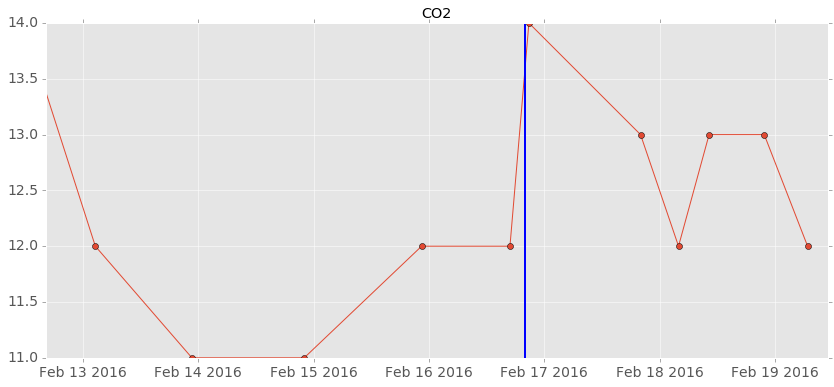

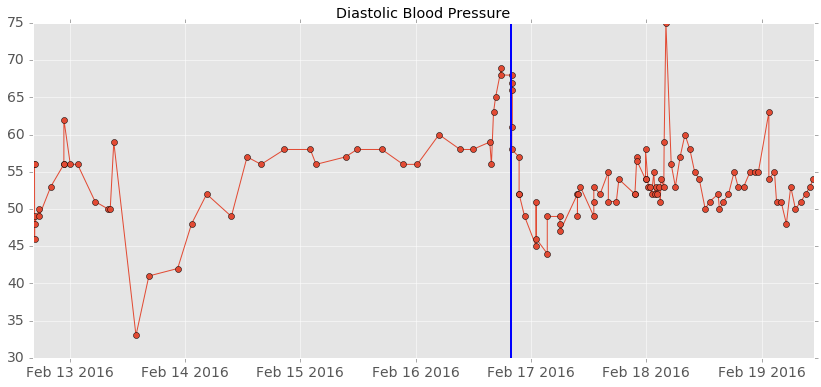

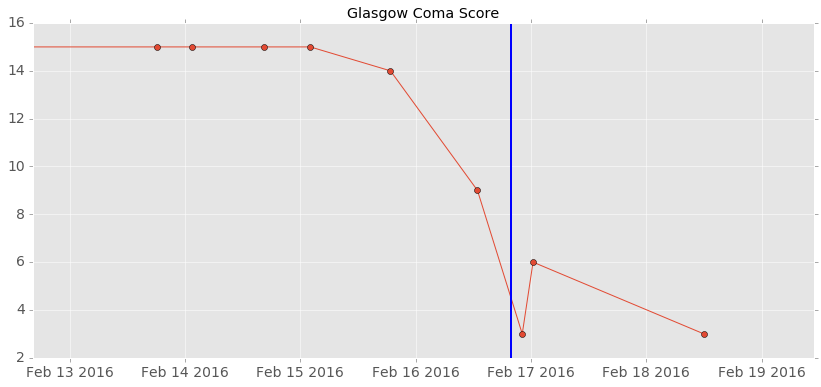

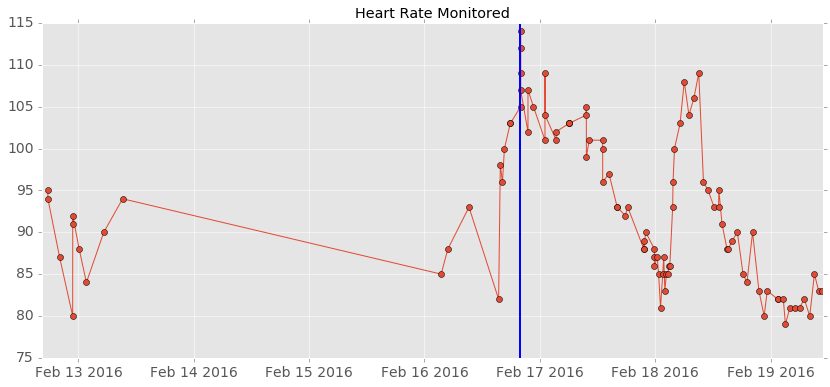

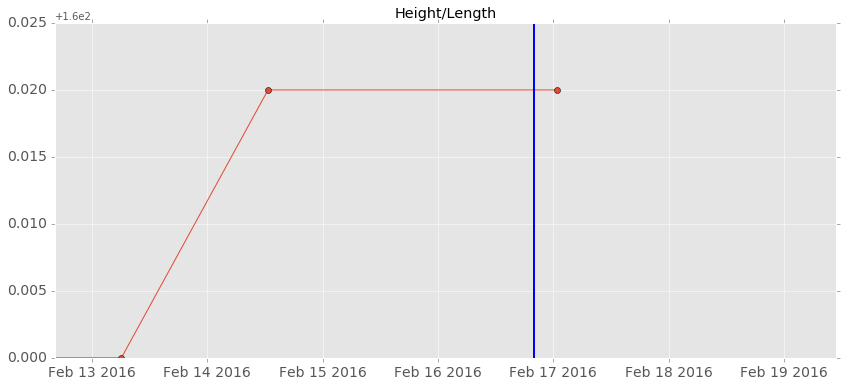

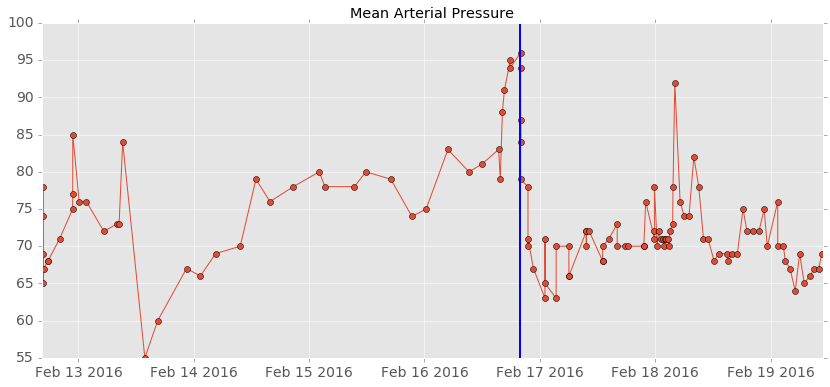

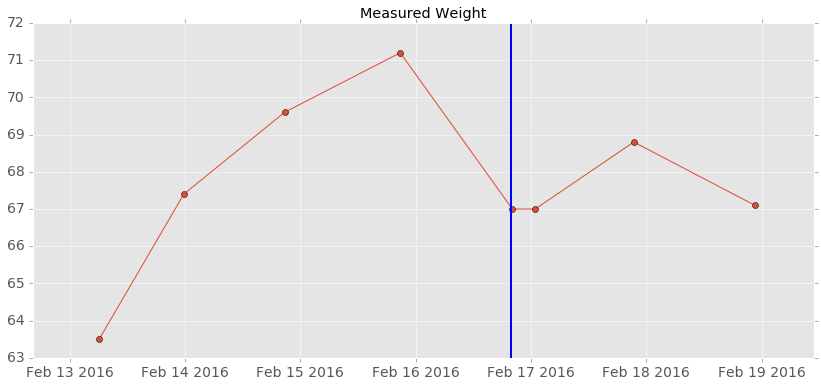

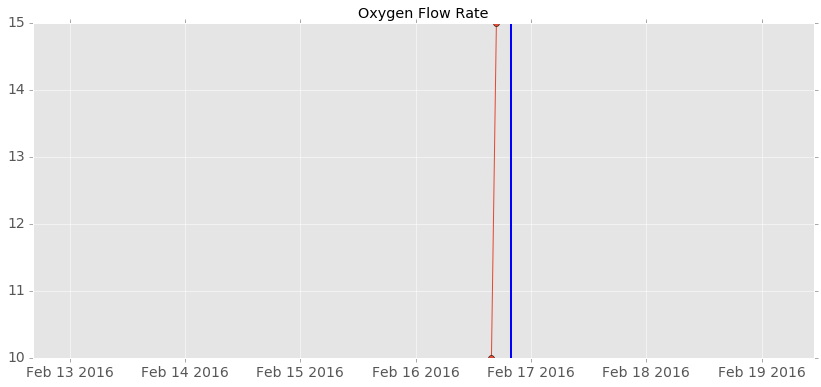

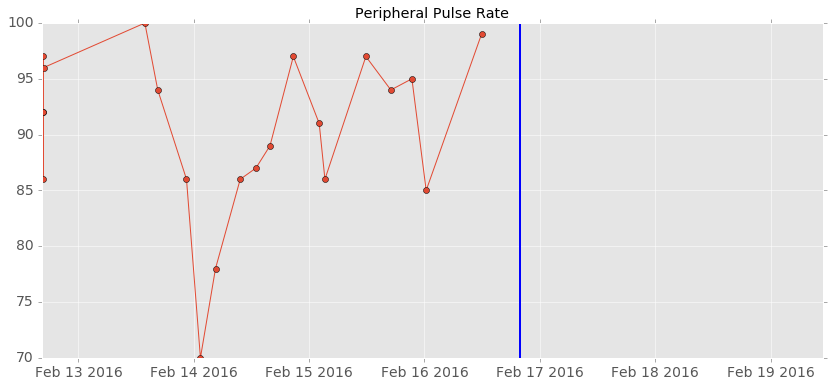

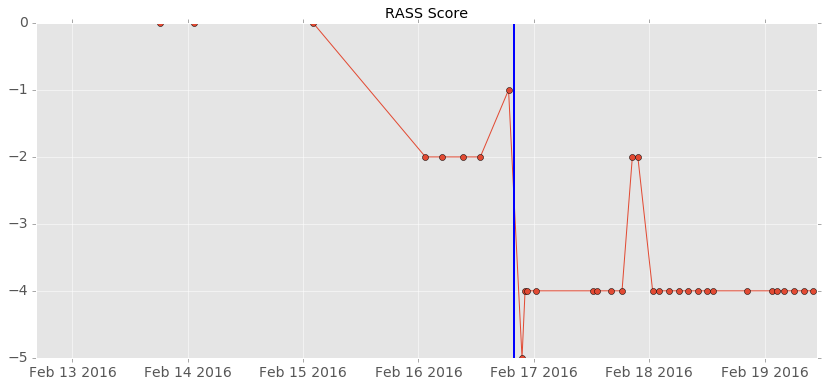

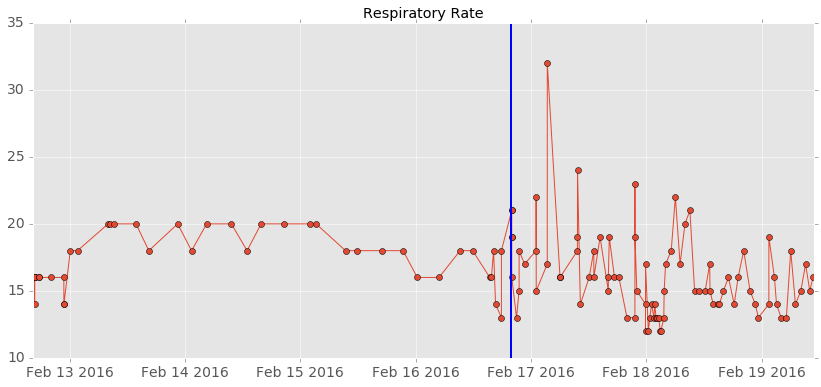

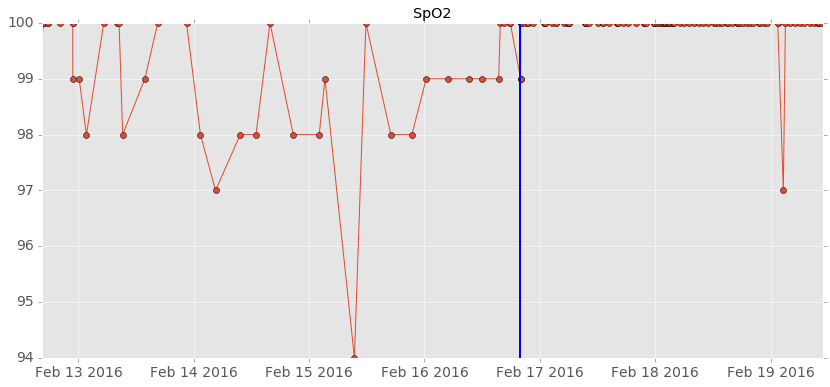

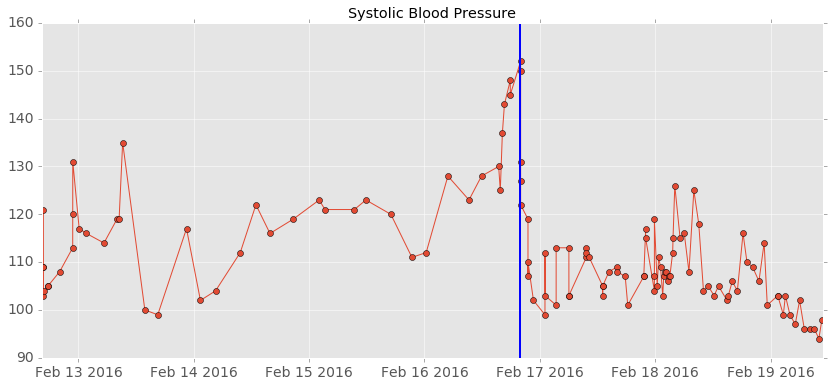

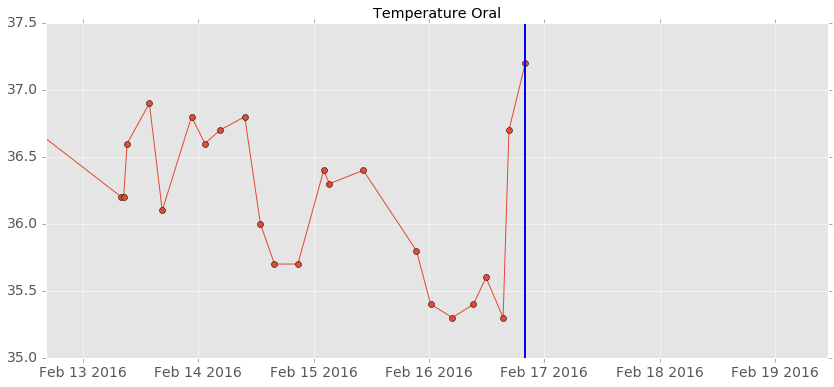

In [25]:
for name in colnames:
    plt.figure(figsize=(14,6))
    mask = np.isfinite(df_new[name])
    plt.plot(df_new[mask].index.to_pydatetime(), df_new[name][mask], '-o')
    plt.title(name)
    plt.tick_params(labelsize=14)
    plt.xlim([arr.to_pydatetime(), dep.to_pydatetime()])

    # add vertical lines when RRT Events took place
    for val in RRT_times:
        plt.axvline(x=val.to_pydatetime(), linewidth = 2)

### Pull the code together in a function. Select encounter randomly!

In [84]:
def timeseries_randomRRTpatient():
    '''
    Query for & plot the vital signs of a patient with an RRT event.
    Currently written to return a random encounter.
    '''
    
    query_encid = "SELECT DISTINCT encntr_id \
                        FROM clinical_event \
                               WHERE event_cd = '54411998' \
                               AND result_status_cd NOT IN ('31', '36') \
                               AND valid_until_dt_tm > unix_timestamp() \
                               AND event_class_cd not in ('654645');"
    # Note - have note checked that encounter has valid end date...
    # And haven't separated by location.
    cur.execute(query_encid)
    RRT_enc_ids = cur.fetchall()
    RRTencids = [enc[0] for enc in RRT_enc_ids]
    enc_id = np.random.choice(RRTencids)
    
    
    query_vitals = "SELECT ce.clinical_event_id, ce.event_id \
    ,ce.encntr_id ,ce.person_id \
    ,ce.event_cd , cv_event_cd.description AS event_description \
    ,ce.performed_dt_tm AS unix_performed_dt_tm \
    ,from_unixtime(CAST(ce.performed_dt_tm   / 1000 as bigint)) AS performed_dt_tm \
    ,ce.event_tag ,ce.result_val ,cv_result_units_cd.display      AS result_units_display \
    ,ce.result_time_units_cd \
    ,ce.catalog_cd \
    FROM clinical_event        ce \
    LEFT OUTER JOIN code_value   cv_event_cd ON   ce.event_cd           = cv_event_cd.code_value \
    LEFT OUTER JOIN code_value   cv_result_units_cd ON   ce.result_units_cd    = cv_result_units_cd.code_value \
    WHERE ce.encntr_id = '{0}' \
    AND ce.event_cd IN ( \
    '703306',\
    '703501',\
    '703511',\
    '703516',\
    '703540',\
    '703558',\
    '703565',\
    '703569',\
    '2700541',\
    '2700653',\
    '3623994',\
    '4674677',\
    '4686698',\
    '4690633',\
    '54411998',\
    '54408578'\
    )\
    ORDER BY ce.encntr_id, ce.performed_dt_tm;".format(enc_id)


    cur.execute(query_vitals)
    df = as_pandas(cur)

    df["timestamp"] = df.performed_dt_tm.apply(lambda x: pd.Timestamp(x))
    df['result_val'] = pd.to_numeric(df.result_val, errors = 'coerce')

    # pivot the data so it's in the format we need for plotting
    df_new = pd.pivot_table(df, values="result_val", index='timestamp', columns = 'event_description')

    # Grab unique RRT event times & convert to right format
    RRTEventTimes = df.unix_performed_dt_tm[df.event_cd == "54411998"].unique()
    RRT_times = [pd.to_datetime(x, unit='ms') for x in RRTEventTimes]

    # get columns to query
    init_colnames = df_new.columns.get_values()
    colnames = [item for item in init_colnames if item not in ["RRT Event Form", "RRT Primary Reason for Call"]]

    # print encounter id
    print "encntr_id: {0}".format(df.encntr_id[0])
    print "RRT reason for call: {0}".format(df[df.event_cd=='54408578']['event_tag'].get_values()[0])

    # pull up & print reason for visit
    query_reason = "SELECT reason_for_visit FROM encounter WHERE encntr_id = '{0}';".format(df.encntr_id[0])
    cur.execute(query_reason)
    reason = cur.fetchall()
    reason = reason[0][0]
    print "Reason for encounter: {0}".format(reason)
    
    # pull dates of encounter so we can set xlim up the right way.
    query_minmaxtimes = "SELECT arrive_dt_tm, depart_dt_tm FROM encounter WHERE encntr_id = '{0}';".format(df.encntr_id[0])
    cur.execute(query_minmaxtimes)
    arr_dep = cur.fetchall()
    arr = pd.to_datetime(arr_dep[0][0], unit="ms")
    dep = pd.to_datetime(arr_dep[0][1], unit="ms")


    # plotting: PLOT ALL THE THINGS
    for name in colnames:
        plt.figure(figsize=(14,8))
        mask = np.isfinite(df_new[name])
        plt.plot(df_new[mask].index.to_pydatetime(), df_new[name][mask], '-o')
        plt.title(name)
        plt.tick_params(labelsize=14)
        plt.xlim([arr.to_pydatetime(), dep.to_pydatetime()])

        # add vertical lines when RRT Events took place
        for val in RRT_times:
            plt.axvline(x=val.to_pydatetime(), linewidth = 2)

encntr_id: 104760329
RRT reason for call: Chest pain
Reason for encounter: ATRIAL FIBRILLATION WITH RAPID VENTRICULAR RESPONSE,NEW ONSET


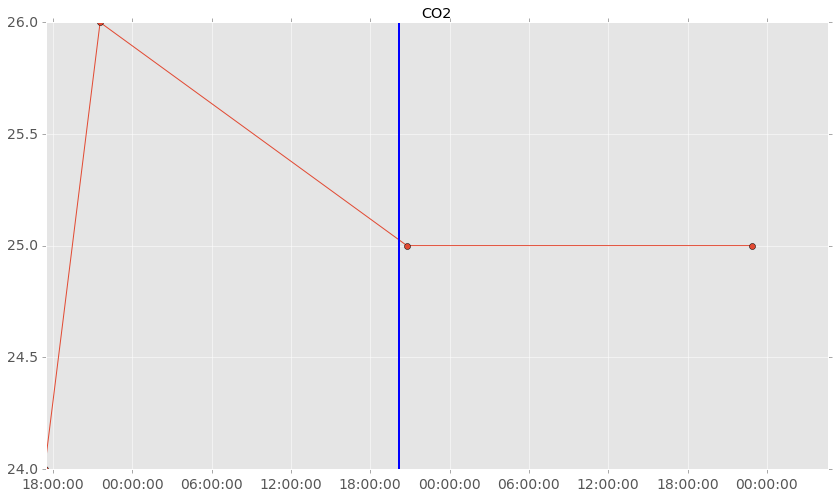

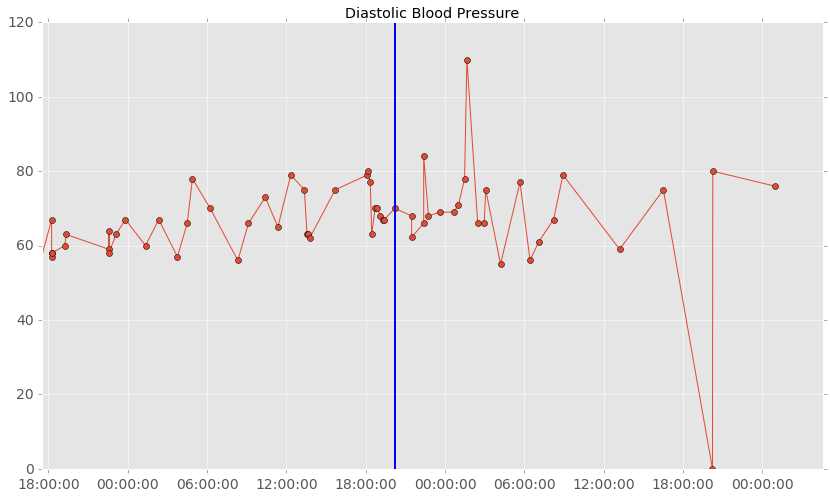

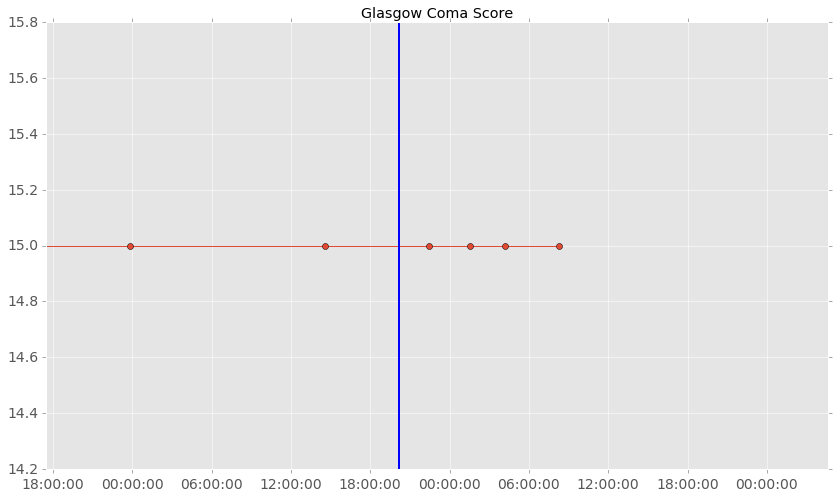

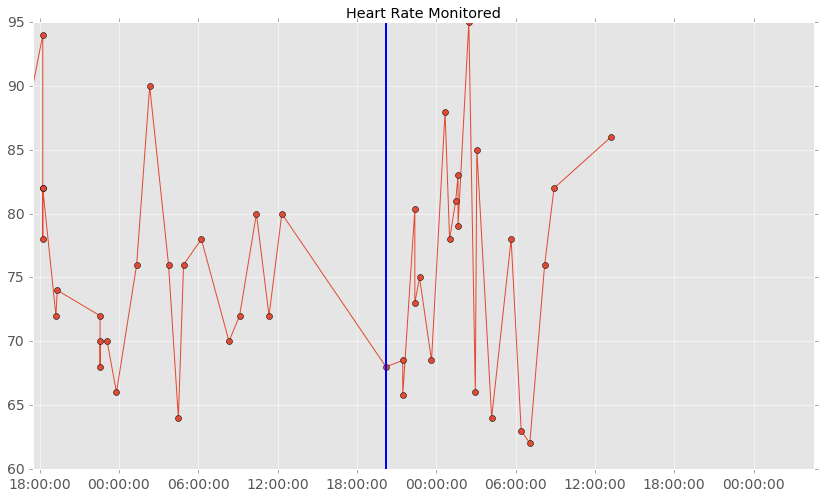

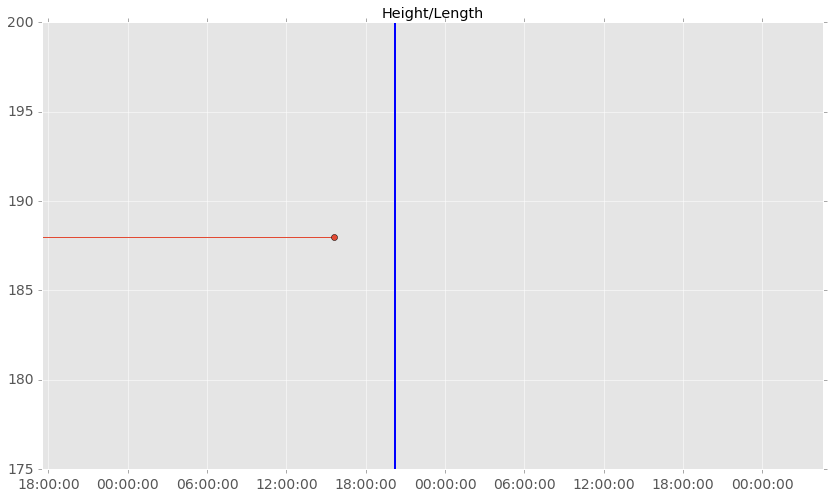

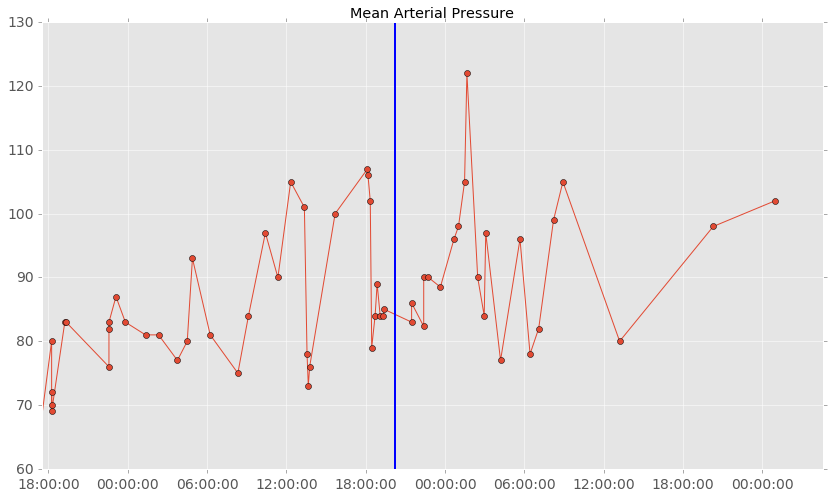

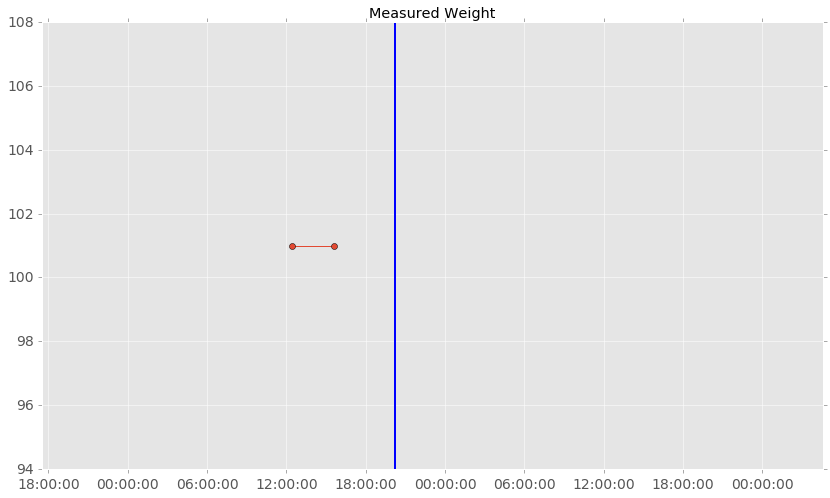

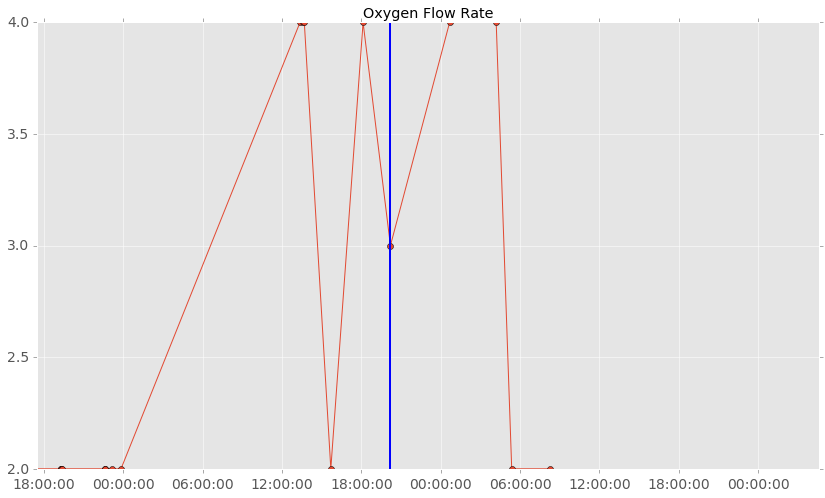

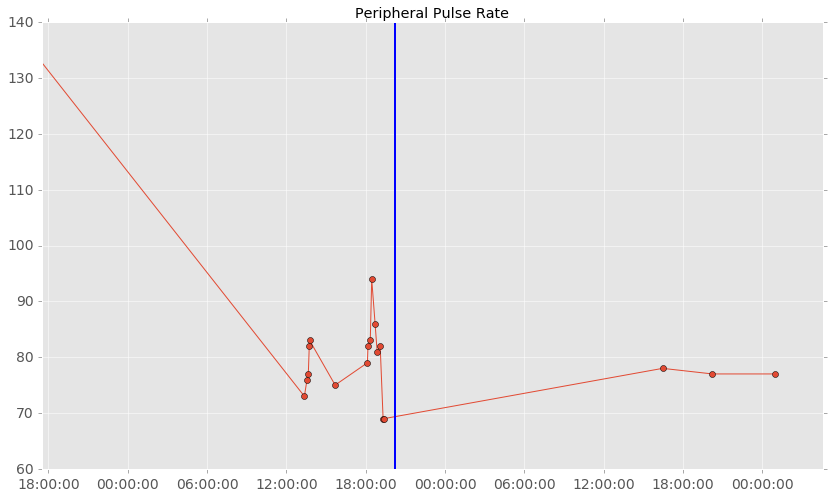

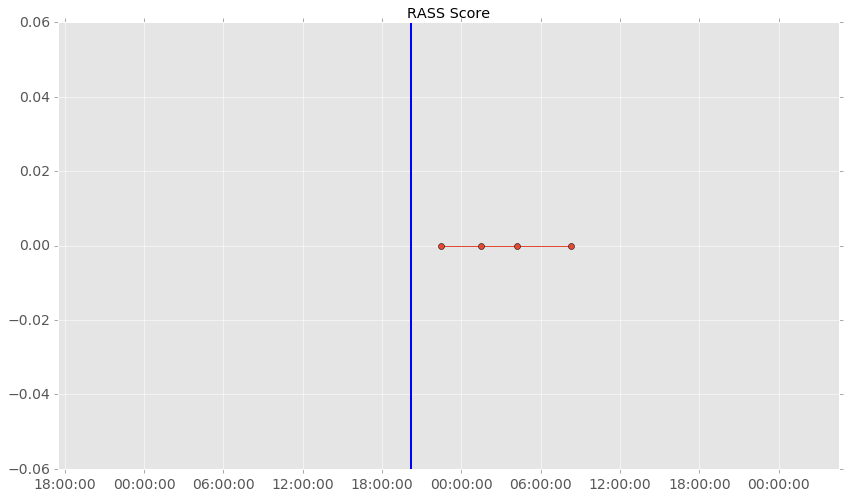

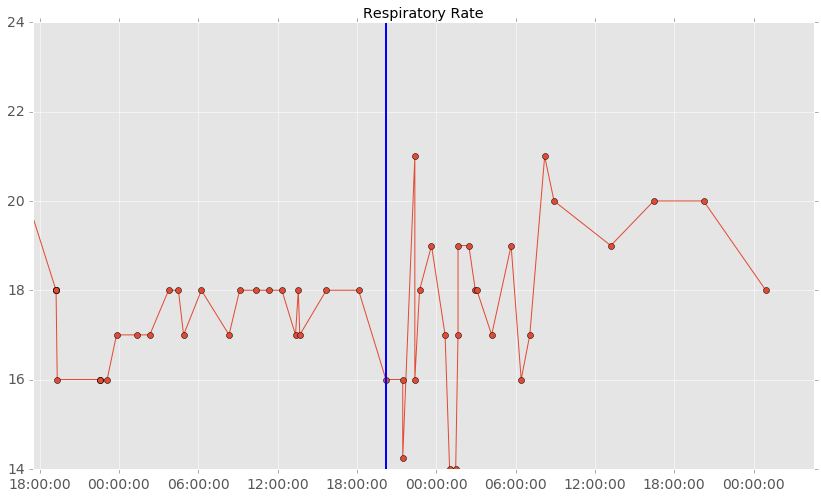

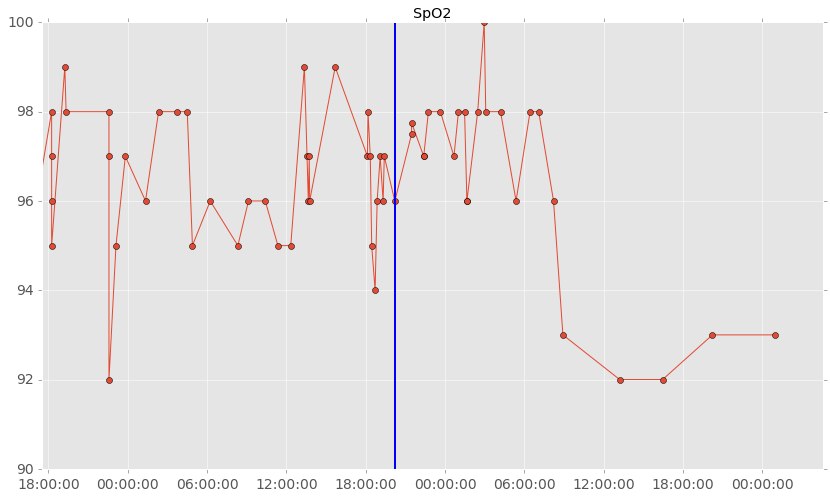

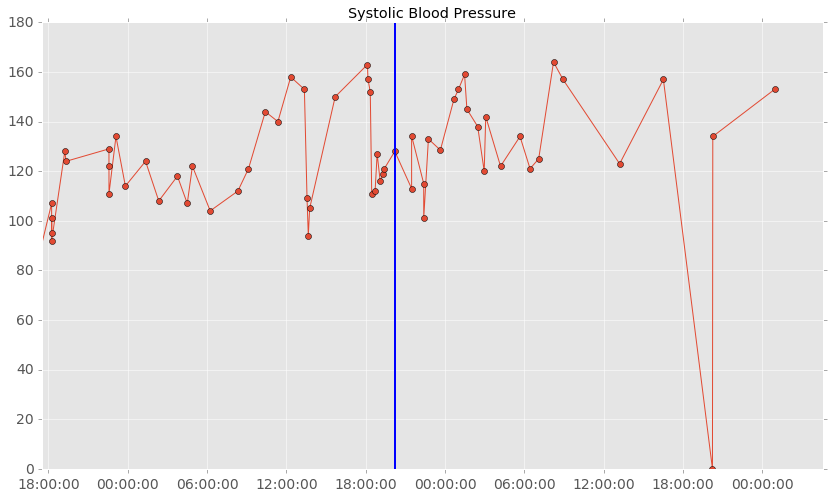

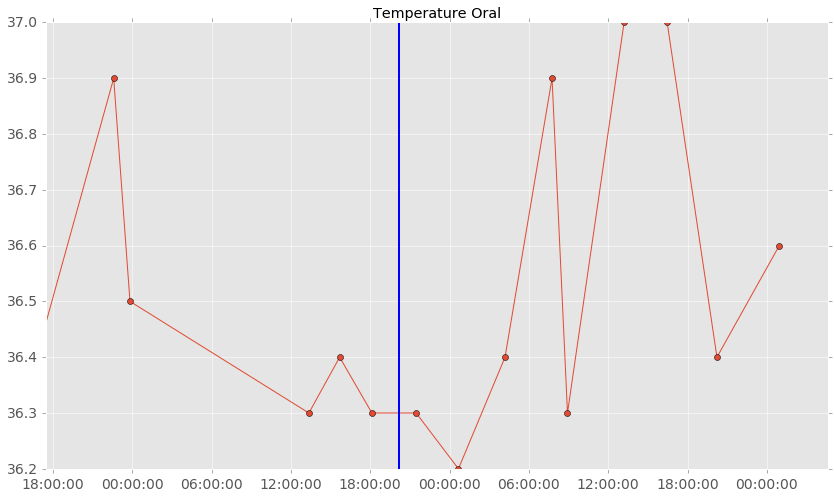

In [91]:
timeseries_randomRRTpatient()

### Ye be warned: graveyard below (aka scratch section notebook)

In [175]:
# Look at event code 703960: Oxygen therapy
df.event_tag[df.event_cd == '703960'].value_counts()

Ventilator                                                                             1321
Trach collar                                                                            316
T-piece                                                                                 313
Nasal cannula                                                                           212
Room air                                                                                179
BIPAP                                                                                    67
CPAP                                                                                     41
CPAP, Ventilator                                                                          9
Ambu bag                                                                                  8
Trach collar, Skin assessed/see Integumentary details, Protective dressing in place       3
Blow-by                                                                         

In [190]:
df.dtypes

clinical_event_id          object
event_id                   object
encntr_id                  object
person_id                  object
event_cd                   object
event_description          object
unix_performed_dt_tm        int64
performed_dt_tm            object
event_start_dt_tm          object
event_end_dt_tm            object
valid_from_dt_tm           object
valid_until_dt_tm          object
class_description          object
event_tag                  object
result_val                 object
result_units_display       object
result_time_units_cd       object
record_status_display      object
result_status_display      object
normalcy_cd                object
normal_low                 object
normal_high                object
critical_low               object
critical_high              object
parent_event_id            object
event_reltn_description    object
catalog_cd                 object
contributor_system_cd      object
subtable_bit_map           object
dtype: object

In [191]:
df_409 = df[df.encntr_id=='107841409']

In [192]:
df_409.head().T

,0,1,2,3,4
clinical_event_id,7566879011,7566879009,7566879007,7566879005,7566879019
event_id,7566879012,7566879010,7566879008,7566879006,7566879020
encntr_id,107841409,107841409,107841409,107841409,107841409
person_id,7907125,7907125,7907125,7907125,7907125
event_cd,703516,703501,703511,703558,3623994
event_description,Diastolic Blood Pressure,Systolic Blood Pressure,Peripheral Pulse Rate,Temperature Oral,SpO2
unix_performed_dt_tm,1461041015000,1461041015000,1461041015000,1461041015000,1461041015000
performed_dt_tm,2016-04-19 04:43:35,2016-04-19 04:43:35,2016-04-19 04:43:35,2016-04-19 04:43:35,2016-04-19 04:43:35
event_start_dt_tm,None,None,None,None,None
event_end_dt_tm,2016-04-19 04:43:00,2016-04-19 04:43:00,2016-04-19 04:43:00,2016-04-19 04:43:00,2016-04-19 04:43:00


In [198]:
RRTs_409 = df_409.unix_performed_dt_tm[df_409.event_cd == '54411998']

In [202]:
RRTs_409

,clinical_event_id,event_id,encntr_id,person_id,event_cd,event_description,unix_performed_dt_tm,performed_dt_tm,event_start_dt_tm,event_end_dt_tm,...,normalcy_cd,normal_low,normal_high,critical_low,critical_high,parent_event_id,event_reltn_description,catalog_cd,contributor_system_cd,subtable_bit_map
50,7568593881,7568593882,107841409,7907125,54411998,RRT Event Form,1461078371000,2016-04-19 15:06:11,None,2016-04-19 13:50:00,...,0,,,,,7568593882,Root,0,469,1073741825
767,7613198935,7613198936,107841409,7907125,54411998,RRT Event Form,1462135694000,2016-05-01 20:48:14,None,2016-05-01 20:48:00,...,0,,,,,7613198936,Root,0,469,1073741825
774,7613200720,7613198936,107841409,7907125,54411998,RRT Event Form,1462135694000,2016-05-01 20:48:14,None,2016-05-01 20:48:00,...,0,,,,,7613198936,Root,0,469,1073741825
782,7613448334,7613448335,107841409,7907125,54411998,RRT Event Form,1462144288000,2016-05-01 23:11:28,None,2016-05-01 22:30:00,...,0,,,,,7613448335,Root,0,469,1073741825
783,7614783708,7613448335,107841409,7907125,54411998,RRT Event Form,1462144288000,2016-05-01 23:11:28,None,2016-05-01 22:30:00,...,0,,,,,7613448335,Root,0,469,1073741825
9703,7772991204,7772991205,107841409,7907125,54411998,RRT Event Form,1466058253000,2016-06-16 06:24:13,None,2016-06-16 04:50:00,...,0,,,,,7772991205,Root,0,469,1073741825
9817,7776405488,7776405489,107841409,7907125,54411998,RRT Event Form,1466137632000,2016-06-17 04:27:12,None,2016-06-17 01:15:00,...,0,,,,,7776405489,Root,0,469,1073741825
12154,7835800410,7835800411,107841409,7907125,54411998,RRT Event Form,1467558265000,2016-07-03 15:04:25,None,2016-07-03 15:04:00,...,0,,,,,7835800411,Root,0,469,1073741825


In [240]:
rrt409_times = df_409.unix_performed_dt_tm[df_409.event_cd == '54411998'].unique()

In [241]:
rrt409_times

array([1461078371000, 1462135694000, 1462144288000, 1466058253000,
       1466137632000, 1467558265000])

In [61]:
# Pull out codes corresponding to these indices = event_cd 
query_common_vitals = 'SELECT code_value, description FROM code_value WHERE code_value IN \
                        ("3623994", "703540", "703516", "703501", "703306", "2700541", \
                         "703960", "703569", "703558", "703511", "4690633", "4686698"\
                         "4674677", 2700635", "703565", "703530");'
cur.execute(query_common_vitals)
df_vitals = as_pandas(cur)
df_vitals

,code_value,description
0,2700535,Temperature Bladder
1,2700541,Heart Rate Monitored
2,703530,Temperature Rectal
3,703535,Temperature Axillary
4,703540,Respiratory Rate
5,703306,Mean Arterial Pressure
6,703960,Oxygen Therapy
7,2700657,FiO2
8,703516,Diastolic Blood Pressure
9,703546,Temperature Intravascular
